In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import glob
import os

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join
from astropy.wcs import WCS
import astropy.units as u

# from specutils.manipulation import box_smooth, gaussian_smooth, trapezoid_smooth
# from specutils.manipulation import median_smooth

from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter

In [2]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 5

In [3]:
# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [4]:
# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

In [5]:
# List of Class 3 Standards from MasterObservationList
# Spectral Types range from K1 to M6
# Will try to put to use later
standards_list = ["Anon1",
"DKTau",
"Haro 6-13",
"HBC 359",
"HBC 427",
"HD 286178",
"HQ Tau",
"Hubble 4",
"JH108",
"JH433",
"LkCa4",
"LkCa14",
"MHO 7",
"MHO 8",
"V410_xray5a",
"V830_tau",
"XEST09-042"
]
# standards_list = standards_list.sort()

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297,
    "CO(2-0)-2.29353" :	2.29353,
    "CO(2-0)-2.32265"	:	2.32265,
    "CO(2-0)-2.34327" :	2.34327,
    "CO(2-0)-2.34531" :	2.34531,
    "CO(2-0)-2.3495" 	:	2.3495,
    "CO(2-0)-2.35167"	:	2.35167,
    "CO(2-0)-2.35246" :	2.35246,
    "CO(2-0)-2.38295" :	2.38295,
}

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

In [6]:
# Wavelength per pixel
df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', header=None)

# Extract wavelength and flux columns
wavelength = df[0]
flux = df[1]
# SNR per res element
snr = df[2]

min_wl = wavelength.min()
max_wl = wavelength.max()
delta_lambda = max_wl-min_wl

tot_num = len(wavelength)

print("Wavelength per pixel: ",delta_lambda/tot_num)

Wavelength per pixel:  1.447528304001794e-05


# Full Wavelength Range of K-Band

In [7]:
# # Iterate over the TXT files
# n = len(merged_standard_files)

# for file in merged_standard_files:
#     # Read the data from the TXT file using pandas
#     df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
#     # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
#     df[2] = df[2].astype(float)

#     # Exclude any negative flux, anything with  10000 < SNR < 5
#     # df[1] = flux df[2] = SNR per resolution element
#     df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
    
#     # Extract wavelength and flux columns
#     wavelength = df[0]
#     flux = df[1]
#     # SNR per res element
#     snr = df[2]

#     # # Smooth the intensity array using Savitzky-Golay filter
#     # smoothed_flux = savgol_filter(flux, window_length=7, polyorder=3)

#     # # Subtract the smoothed intensity from the original intensity to get the continuum
#     # continuum = flux - smoothed_flux

#     # Apply median filtering to the flux column
#     window_size = 801  # Size of the median filter window
#     filtered_flux = medfilt(flux, kernel_size=window_size)
    
#     # Set 
#     fig,ax = plt.subplots(figsize=(15,10))

#     # Create a plot of wavelength vs. flux
#     ax.plot(wavelength, flux,c='black',label='Original Flux')
#     ax.plot(wavelength, filtered_flux,c='cyan', label='Median Filtered Flux')
#     # ax.plot(wavelength, flux/filtered_flux,c='black', label='Flux/med_filt Flux')

#     # ax.set_xscale('log')
#     # ax.set_yscale('log')
#     # ax.set_xlim(2.08,2.37)
#     ax.set_xlabel('Wavelength ($\mu$m)')
#     ax.set_ylabel('Flux (counts)')

#     # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
#     # Iterate over number of objects
#     # for i in range(n):
#     #     # Iterate over the NIR dictionary
#     #     for ii in range(len(lines_wav)):
#     #         ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
#     #         # ax.set_xscale('log')
#     #         # ax.set_yscale('log')

#     # This is the wavelength range from the proposal (Figures 7 and 8)


#     # Extract the filename from the path
#     filename = os.path.splitext(os.path.basename(file))[0]

#     # Make the title according to the filename
#     ax.set_title('K-Band Spectrum for {}'.format(filename))
#     ax.legend(loc='best')

#     # Save the plot as PNG
#     # plt.savefig(fig_path+'{}.png'.format(filename))
    
#     # Show the plot
#     plt.show()
#     # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
#     # plt.close()

## Trying to recreate Nicole's Standards plot

In [8]:
merged_standard_files

['A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mAnon1_M05.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHBC427_K6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHubble4_K8.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mJH108_M15.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa14_K5.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa1_M4.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa4_M2.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV410-Xray5a_M6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV830Tau_K75.txt']

## Data from .txt files

In [9]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Apply median filtering to the flux column
window_size = 1001  # Size of the median filter window

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
anon1_df = anon1_df[(anon1_df['Flux'] > 0) & (anon1_df['SNR'] > 5) & (anon1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']
# # Median Filter
anon1_medflux = median_filter(anon1_flux,size=window_size)
##################

# HBC 427
hbc427_df = pd.read_csv(merged_standard_files[1], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
hbc427_df['SNR'] = hbc427_df['SNR'].astype(float)

# No negative flux and require SNR > 5
hbc427_df = hbc427_df[(hbc427_df['Flux'] > 0) & (hbc427_df['SNR'] > 5) & (hbc427_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
hbc427_wavlen = hbc427_df['Wavelength']
hbc427_flux = hbc427_df['Flux']
# # Median Filter
hbc427_medflux = median_filter(hbc427_flux,size=window_size)
##################

# Hubble 4
hubble4_df = pd.read_csv(merged_standard_files[2], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
hubble4_df['SNR'] = hubble4_df['SNR'].astype(float)

# No negative flux and require SNR > 5
hubble4_df = hubble4_df[(hubble4_df['Flux'] > 0) & (hubble4_df['SNR'] > 5) & (hubble4_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
hubble4_wavlen = hubble4_df['Wavelength']
hubble4_flux = hubble4_df['Flux']
# # Median Filter
hubble4_medflux = median_filter(hubble4_flux,size=window_size)
##################

jh108_df = pd.read_csv(merged_standard_files[3], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
jh108_df['SNR'] = jh108_df['SNR'].astype(float)

# No negative flux and require SNR > 5
jh108_df = jh108_df[(jh108_df['Flux'] > 0) & (jh108_df['SNR'] > 5) & (jh108_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
jh108_wavlen = jh108_df['Wavelength']
jh108_flux = jh108_df['Flux']
# # Median Filter
jh108_medflux = median_filter(jh108_flux,size=window_size)
##################

Lkca14_df = pd.read_csv(merged_standard_files[4], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
Lkca14_df['SNR'] = Lkca14_df['SNR'].astype(float)

# No negative flux and require SNR > 5
Lkca14_df = Lkca14_df[(Lkca14_df['Flux'] > 0) & (Lkca14_df['SNR'] > 5) & (Lkca14_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
Lkca14_wavlen = Lkca14_df['Wavelength']
Lkca14_flux = Lkca14_df['Flux']
# # Median Filter
Lkca14_medflux = median_filter(Lkca14_flux,size=window_size)
##################

Lkca1_df = pd.read_csv(merged_standard_files[5], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
Lkca1_df['SNR'] = Lkca1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
Lkca1_df = Lkca1_df[(Lkca1_df['Flux'] > 0) & (Lkca1_df['SNR'] > 5) & (Lkca1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
Lkca1_wavlen = Lkca1_df['Wavelength']
Lkca1_flux = Lkca1_df['Flux']
# # Median Filter
Lkca1_medflux = median_filter(Lkca1_flux,size=window_size)
##################

Lkca4_df = pd.read_csv(merged_standard_files[6], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
Lkca4_df['SNR'] = Lkca4_df['SNR'].astype(float)

# No negative flux and require SNR > 5
Lkca4_df = Lkca4_df[(Lkca4_df['Flux'] > 0) & (Lkca4_df['SNR'] > 5) & (Lkca4_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
Lkca4_wavlen = Lkca4_df['Wavelength']
Lkca4_flux = Lkca4_df['Flux']
# # Median Filter
Lkca4_medflux = median_filter(Lkca4_flux,size=window_size)
##################

v410_df = pd.read_csv(merged_standard_files[7], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
v410_df['SNR'] = v410_df['SNR'].astype(float)

# No negative flux and require SNR > 5
v410_df = v410_df[(v410_df['Flux'] > 0) & (v410_df['SNR'] > 5) & (v410_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
v410_wavlen = v410_df['Wavelength']
v410_flux = v410_df['Flux']
# # Median Filter
v410_medflux = median_filter(v410_flux,size=window_size)
##################

v830tau_df = pd.read_csv(merged_standard_files[8], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is in string for some reason, change to float
v830tau_df['SNR'] = v830tau_df['SNR'].astype(float)

# No negative flux and require SNR > 5
v830tau_df = v830tau_df[(v830tau_df['Flux'] > 0) & (v830tau_df['SNR'] > 5) & (v830tau_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
v830tau_wavlen = v830tau_df['Wavelength']
v830tau_flux = v830tau_df['Flux']
# # Median Filter
v830tau_medflux = median_filter(v830tau_flux,size=window_size)

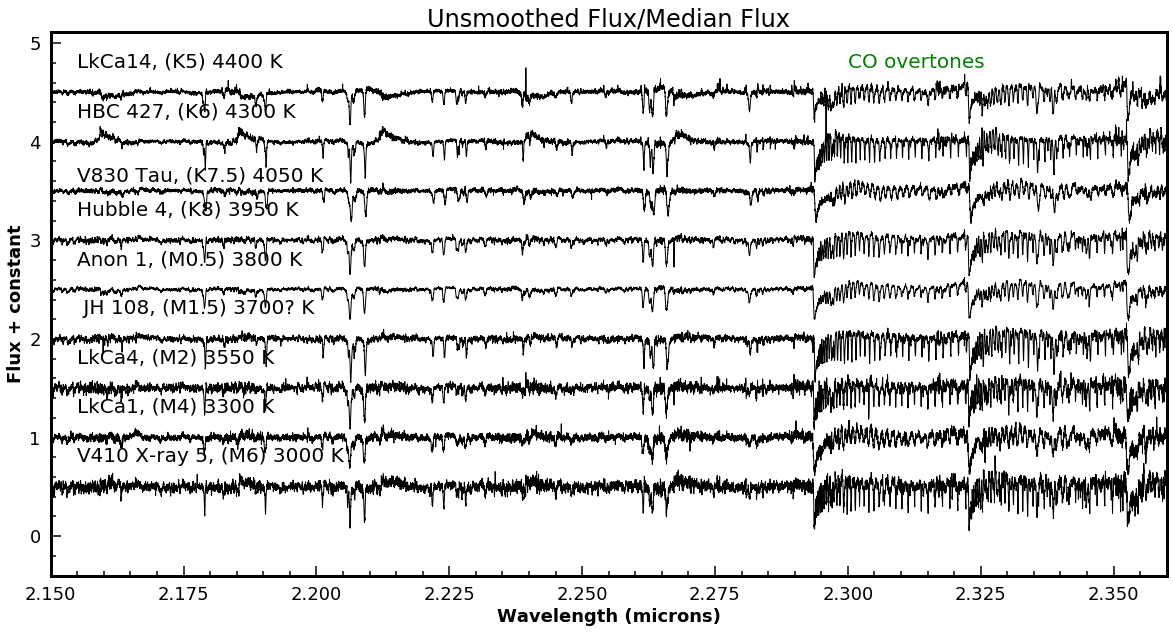

In [19]:
# Comment later because you're a lazy bum
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(Lkca14_wavlen,Lkca14_flux/Lkca14_medflux+3.5,linewidth=1,c='black')
ax.text(2.155,4.75,'LkCa14, (K5) 4400 K')

plt.plot(hbc427_wavlen,hbc427_flux/hbc427_medflux + 3,linewidth=1,c='black')
ax.text(2.155,4.25,'HBC 427, (K6) 4300 K')

plt.plot(v830tau_wavlen,v830tau_flux/v830tau_medflux+2.5,linewidth=1,c='black')
ax.text(2.155,3.6,'V830 Tau, (K7.5) 4050 K')

plt.plot(hubble4_wavlen,hubble4_flux/hubble4_medflux + 2,linewidth=1,c='black')
ax.text(2.155,3.25,'Hubble 4, (K8) 3950 K')

plt.plot(anon1_wavlen,anon1_flux/anon1_medflux+1.5, linewidth=1,c='black')
ax.text(2.155,2.75,'Anon 1, (M0.5) 3800 K')

plt.plot(jh108_wavlen,jh108_flux/jh108_medflux+1,linewidth=1,c='black')
ax.text(2.155,2.25,' JH 108, (M1.5) 3700? K')

plt.plot(Lkca4_wavlen,Lkca4_flux/Lkca4_medflux+0.5,linewidth=1,c='black')
ax.text(2.155,1.75,'LkCa4, (M2) 3550 K')

plt.plot(Lkca1_wavlen,Lkca1_flux/Lkca1_medflux,linewidth=1,c='black')
ax.text(2.155,1.25,'LkCa1, (M4) 3300 K')

plt.plot(v410_wavlen,v410_flux/v410_medflux-0.5,linewidth=1,c='black')
ax.text(2.155,0.75,'V410 X-ray 5, (M6) 3000 K')

# CO Overtones
ax.text(2.3,4.75,'CO overtones',color='g')

# ax.set_xscale('log')
# ax.set_yscale('log')

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Set the tick parameters
ax.tick_params(axis='both', which='major', direction='in', width=1.5, length=10, pad=10)
ax.tick_params(axis='both', which='minor', direction='in', width=1.5, length=5, pad=10)

plt.xlim(2.15,2.36)
# plt.ylim(0,5)

plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux + constant')
# plt.legend()
plt.title('Unsmoothed Flux/Median Flux')
plt.savefig(fig_path+'standards_2.15_2.25.png')

plt.show()

## Smoothing

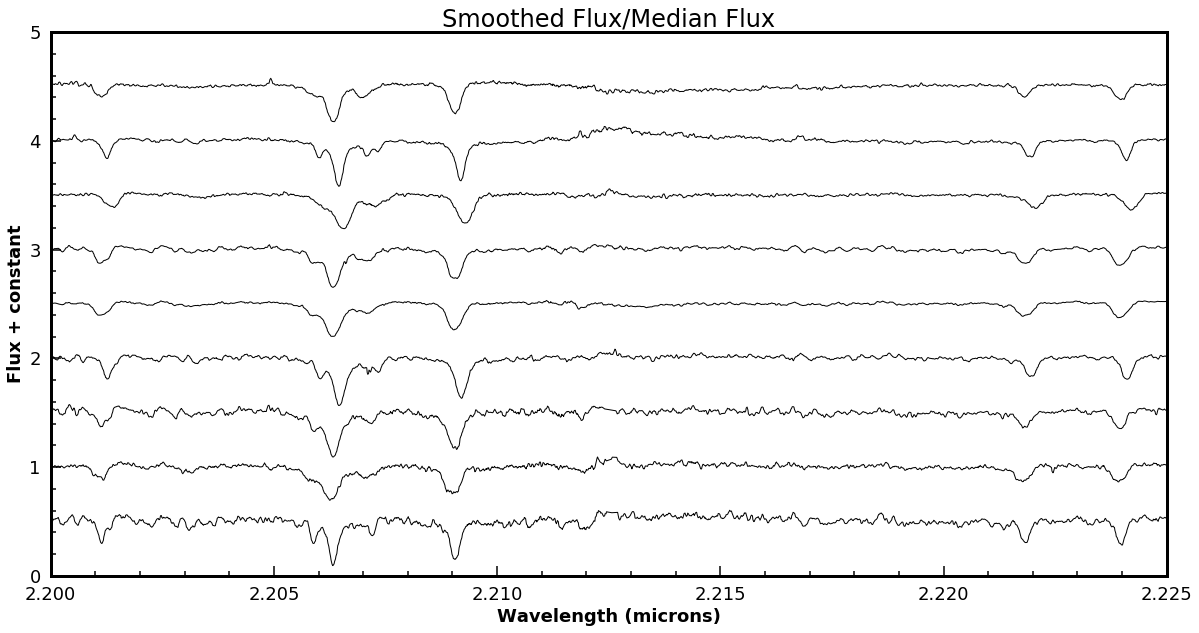

In [22]:
# SciPy Savitzky-Golay filter settings
filt_window = 3
poly_order = 1
# savgol_filter(x,window_length=filt_window,polyorder=poly_order)

# Comment later because you're a lazy bum
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(Lkca14_wavlen,savgol_filter(Lkca14_flux/Lkca14_medflux+3.5,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')


plt.plot(hbc427_wavlen,savgol_filter(hbc427_flux/hbc427_medflux+3,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')


plt.plot(v830tau_wavlen,savgol_filter(v830tau_flux/v830tau_medflux+2.5,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')

plt.plot(hubble4_wavlen,savgol_filter(hubble4_flux/hubble4_medflux+2,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')

plt.plot(anon1_wavlen,savgol_filter(anon1_flux/anon1_medflux+1.5,window_length=filt_window,polyorder=poly_order), linewidth=1,c='black')

plt.plot(jh108_wavlen,savgol_filter(jh108_flux/jh108_medflux+1,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')

plt.plot(Lkca4_wavlen,savgol_filter(Lkca4_flux/Lkca4_medflux+0.5,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')

plt.plot(Lkca1_wavlen,savgol_filter(Lkca1_flux/Lkca1_medflux,window_length=filt_window,polyorder=poly_order),linewidth=1,c='black')

plt.plot(v410_wavlen,savgol_filter(v410_flux/v410_medflux-0.5,window_length=filt_window, polyorder=poly_order),linewidth=1,c='black')


# ax.text(2.155,4.75,'K5 LkCa14, 4400 K')
# ax.text(2.155,4.25,'K6 HBC 427, 4300 K')
# ax.text(2.155,3.6,'K7.5 V830 Tau, 4050 K')
# ax.text(2.155,3.25,'K8 Hubble 4, 3950 K')
# ax.text(2.155,2.75,'M0.5 Anon 1, 3800 K')
# ax.text(2.155,2.25,'M1.5 JH 108, 3700? K')
# ax.text(2.155,1.75,'M2 LkCa4, 3550 K')
# ax.text(2.155,1.25,'M4 LkCa1, 3300 K')
# ax.text(2.155,0.75,'M6 V410 X-ray 5, 3000 K')
# # CO Overtones
# ax.text(2.3,4.75,'CO overtones',color='g')

# ax.set_xscale('log')
# ax.set_yscale('log')

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Set the tick parameters
ax.tick_params(axis='both', which='major', direction='in', width=1.5, length=10, pad=10)
ax.tick_params(axis='both', which='minor', direction='in', width=1.5, length=5, pad=10)

# plt.xlim(2.15,2.36)
plt.xlim(2.2,2.225)
plt.ylim(0,5)

plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux + constant')
# plt.legend()
plt.title('Smoothed Flux/Median Flux')
plt.savefig(fig_path+'standards_smoothed_overplot.png')

plt.show()

# 2.08-2.37 Micron

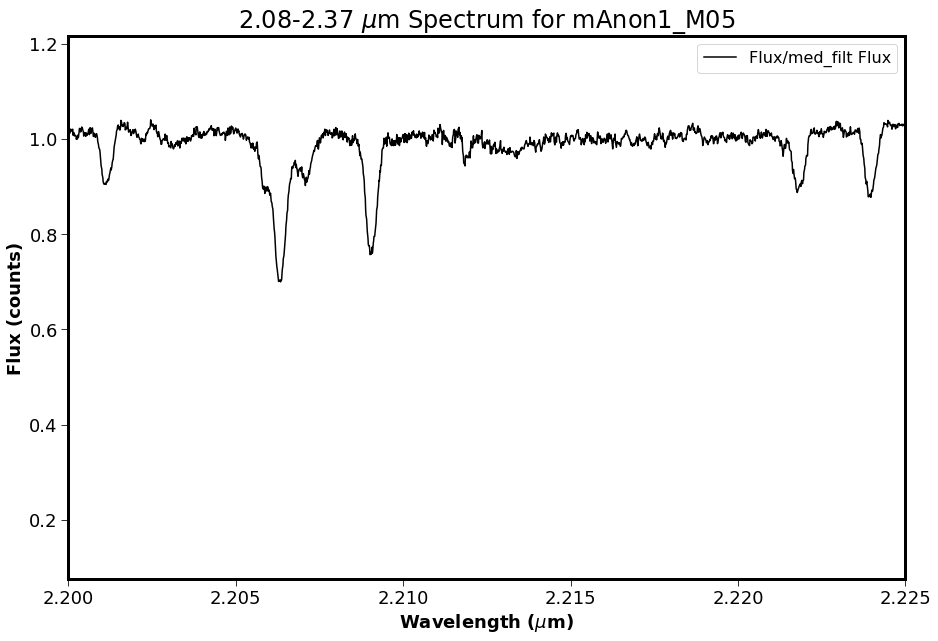

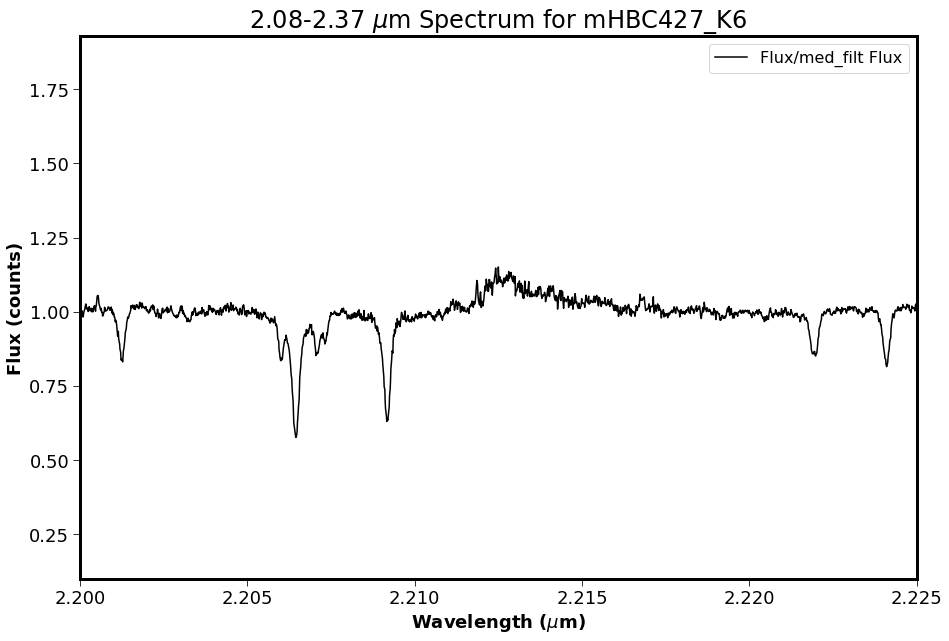

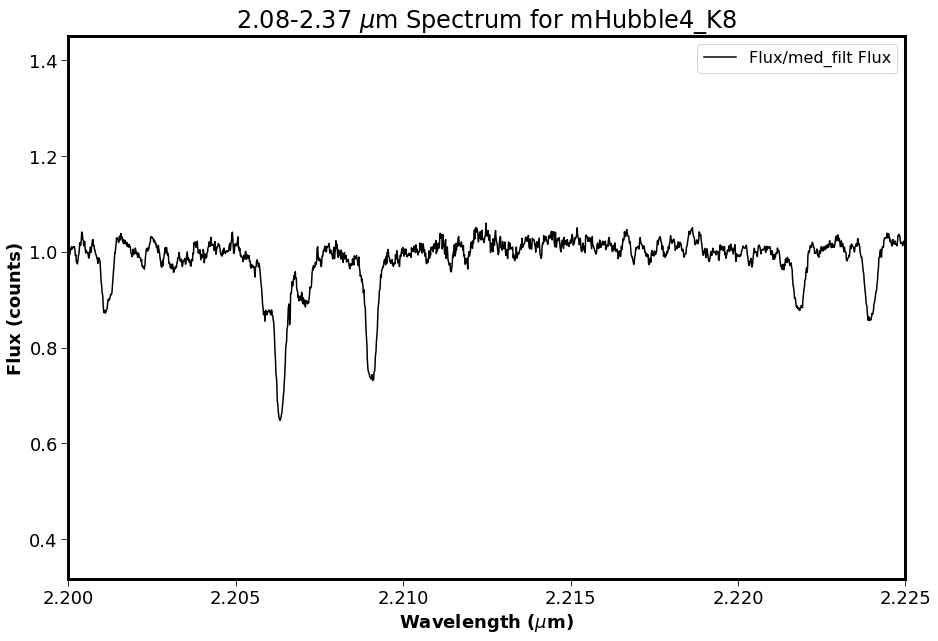

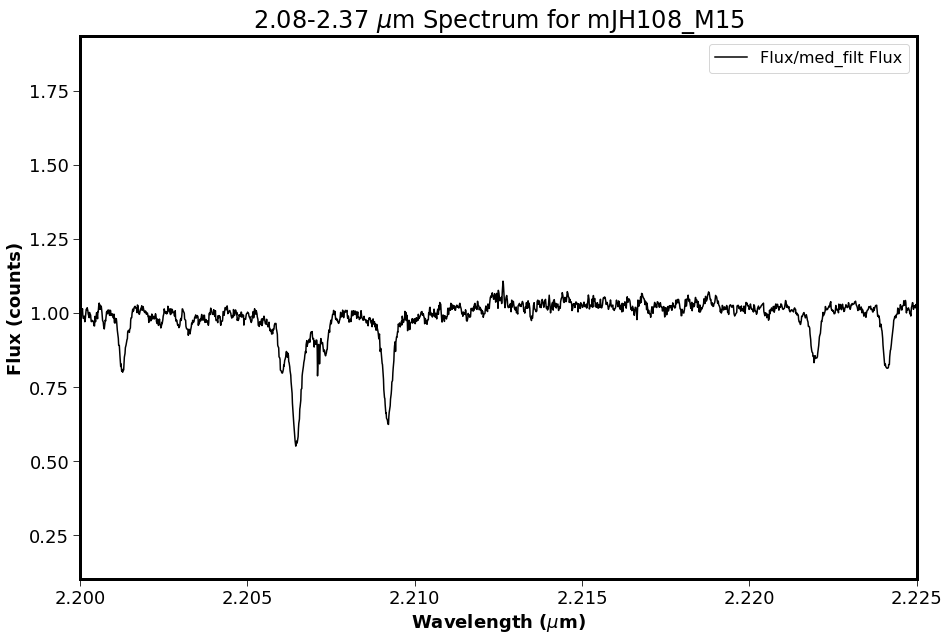

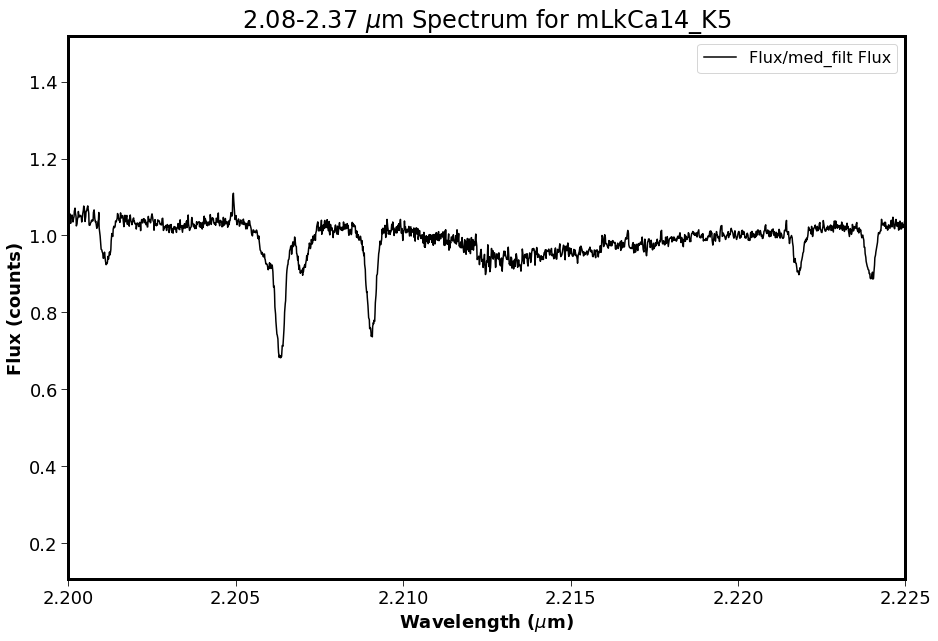

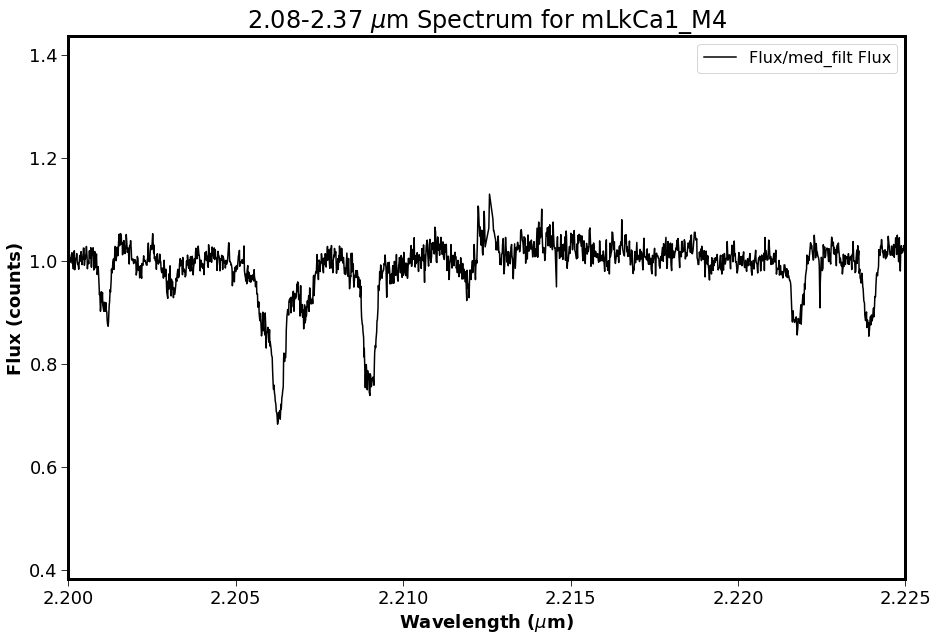

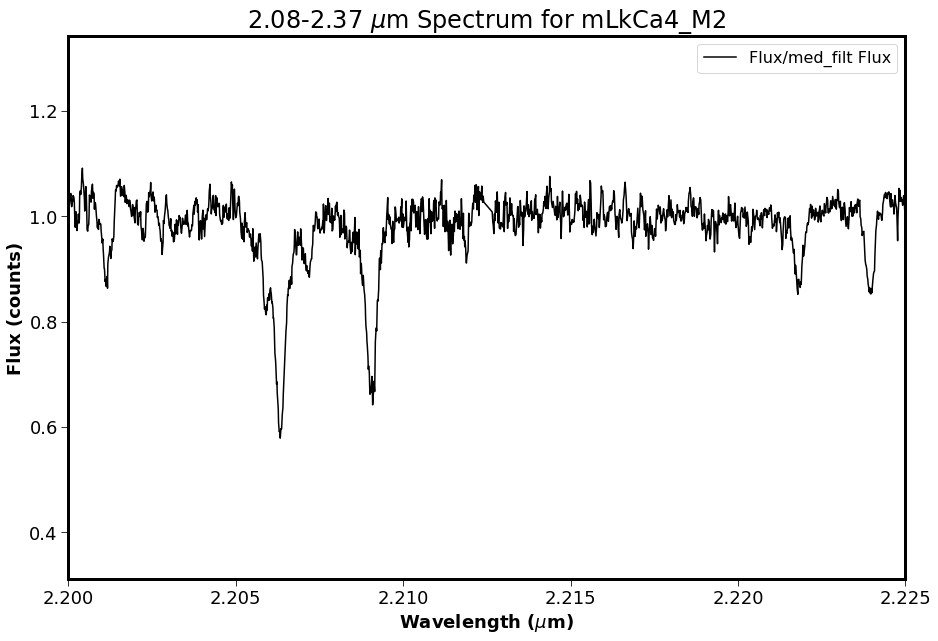

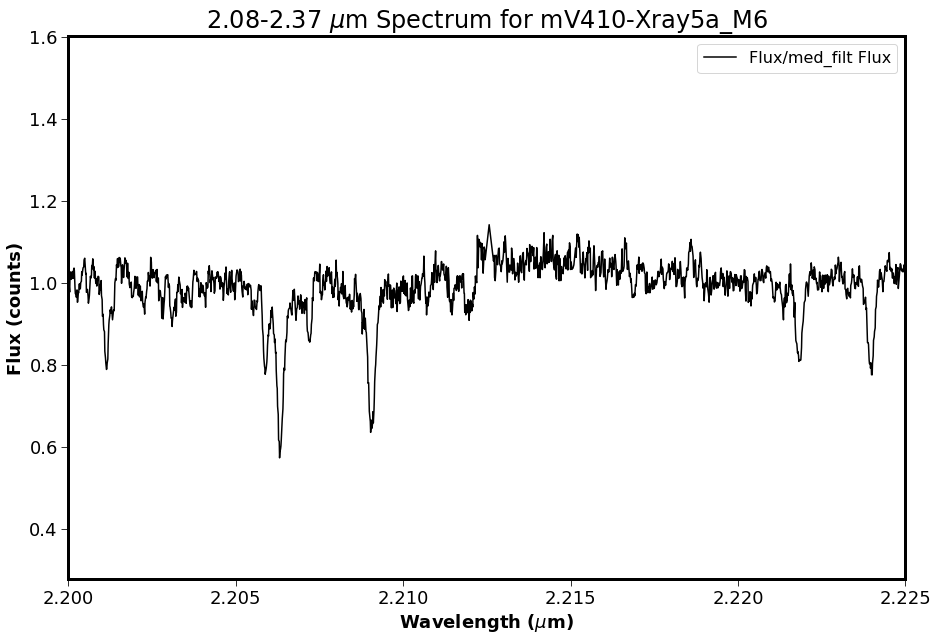

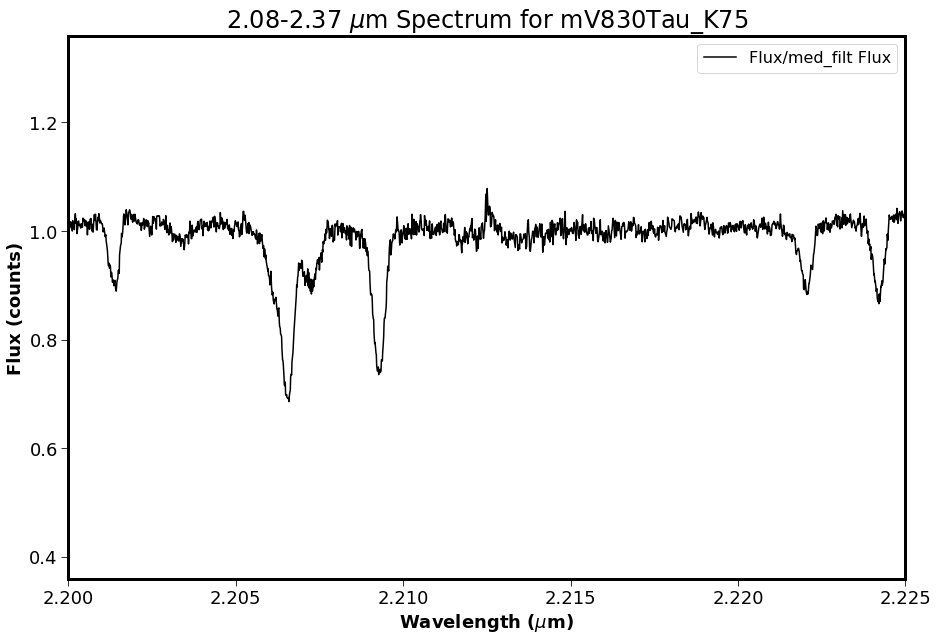

In [23]:
# Who knows if this will work
# from scipy.signal import savgol_filter

# Iterate over the TXT files
n = len(merged_standard_files)

for file in merged_standard_files:
    # Read the data from the TXT file using pandas
    df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
    # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
    df[2] = df[2].astype(float)

    # Exclude any negative flux, anything with  10000 < SNR < 5
    # df[1] = flux df[2] = SNR per resolution element
    df = df[(df[1] > 0) & (df[2] > 5) & (df[2] < 10000)]
    
    # Extract wavelength and flux columns
    wavelength = df[0]
    flux = df[1]
    # SNR per res element
    snr = df[2]

    # # Smooth the intensity array using Savitzky-Golay filter
    # smoothed_flux = savgol_filter(flux, window_length=7, polyorder=3)

    # # Subtract the smoothed intensity from the original intensity to get the continuum
    # continuum = flux - smoothed_flux

    # Apply median filtering to the flux column
    window_size = 5001  # Size of the median filter window
    filtered_flux = median_filter(flux, size=window_size)   # medfilt; median_filter
    
    # Set 
    fig,ax = plt.subplots(figsize=(15,10))

    # Create a plot of wavelength vs. flux
    # ax.plot(wavelength, flux,c='black',label='Original Flux')
    # ax.plot(wavelength, filtered_flux,c='red', label='Median Filtered Flux')
    ax.plot(wavelength, flux/filtered_flux,c='black', label='Flux/med_filt Flux')

    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim(2.08,2.37)
    plt.xlim(2.2,2.225)
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.set_ylabel('Flux (counts)')

    # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
    # Iterate over number of objects
    # for i in range(n):
    #     # Iterate over the NIR dictionary
    #     for ii in range(len(lines_wav)):
    #         ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
    #         # ax.set_xscale('log')
    #         # ax.set_yscale('log')

    # This is the wavelength range from the proposal (Figures 7 and 8)


    # Extract the filename from the path
    filename = os.path.splitext(os.path.basename(file))[0]

    # Make the title according to the filename
    ax.set_title('2.08-2.37 $\mu$m Spectrum for {}'.format(filename))
    ax.legend(loc='best')

    # Save the plot as PNG
    plt.savefig(fig_path+'{}.png'.format(filename))
    
    # Show the plot
    plt.show()
    # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
    # plt.close()

# Wavelength Ranges from Nolan's Drive

In [13]:
# # Iterate over the TXT files
# n = len(merged_standard_files)

# for file in merged_standard_files:
#     # Read the data from the TXT file using pandas
#     df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
#     # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
#     df[2] = df[2].astype(float)
#     # Exclude any negative flux, anything with  10000 < SNR < 5 only because I don't actually know what the 3rd column is
#     df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
#     # Extract wavelength and flux columns
#     wavelength = df[0]
#     flux = df[1]
#     # Set 
#     fig,ax = plt.subplots(figsize=(15,10))

#     # Create a plot of wavelength vs. flux
#     # ax.scatter(wavelength, flux,s=2,c='black')
#     ax.plot(wavelength, flux,c='black')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
#     # Iterate over number of objects
#     for i in range(n):
#         # Iterate over the NIR dictionary
#         for ii in range(len(lines_wav)):
#             ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
#             # ax.set_xscale('log')
#             # ax.set_yscale('log')
            
#     ax.set_xlim(2.080,2.115)
#     ax.set_xlabel('Wavelength ($\mu$m)')
#     ax.set_ylabel('Flux (counts)')

#     # Extract the filename from the path
#     filename = os.path.splitext(os.path.basename(file))[0]
#     # Make the title according to the filename
#     ax.set_title('Spectrum for {}'.format(filename))
    
#     # Save the plot as PNG
#     plt.savefig(fig_path+'2.080-2.115/'+'{}.png'.format(filename))
    
#     # Create the folder if it doesn't exist
#     if not os.path.exists(fig_path+'2.080-2.115'):
#         os.makedirs(fig_path+'2.080-2.115')
#     # Show the plot
#     plt.show()
#     # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
#     plt.close()

In [14]:
# # Iterate over the TXT files
# n = len(merged_standard_files)

# for file in merged_standard_files:
#     # Read the data from the TXT file using pandas
#     df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
#     # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
#     df[2] = df[2].astype(float)
#     # Exclude any negative flux, anything with  10000 < SNR < 5 only because I don't actually know what the 3rd column is
#     df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
#     # Extract wavelength and flux columns
#     wavelength = df[0]
#     flux = df[1]
#     # Set 
#     fig,ax = plt.subplots(figsize=(15,10))

#     # Create a plot of wavelength vs. flux
#     # ax.scatter(wavelength, flux,s=2,c='black')
#     ax.plot(wavelength, flux,c='black')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
#     # Iterate over number of objects
#     for i in range(n):
#         # Iterate over the NIR dictionary
#         for ii in range(len(lines_wav)):
#             ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
#             # ax.set_xscale('log')
#             # ax.set_yscale('log')
            
#     ax.set_xlim(2.130,2.190)
#     ax.set_xlabel('Wavelength ($\mu$m)')
#     ax.set_ylabel('Flux (counts)')

#     # Extract the filename from the path
#     filename = os.path.splitext(os.path.basename(file))[0]
#     # Make the title according to the filename
#     ax.set_title('Spectrum for {}'.format(filename))
    
#     # Save the plot as PNG

#     # Create the folder if it doesn't exist
#     if not os.path.exists(fig_path+'2.130-2.190'):
#         os.makedirs(fig_path+'2.130-2.190')
        
#     plt.savefig(fig_path+'2.130-2.190/'+'{}.png'.format(filename))
#     # Show the plot
#     plt.show()
#     # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
#     plt.close()

In [15]:
# # Iterate over the TXT files
# n = len(merged_standard_files)

# for file in merged_standard_files:
#     # Read the data from the TXT file using pandas
#     df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
#     # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
#     df[2] = df[2].astype(float)
#     # Exclude any negative flux, anything with  10000 < SNR < 5 only because I don't actually know what the 3rd column is
#     df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
#     # Extract wavelength and flux columns
#     wavelength = df[0]
#     flux = df[1]
#     # Set 
#     fig,ax = plt.subplots(figsize=(15,10))

#     # Create a plot of wavelength vs. flux
#     # ax.scatter(wavelength, flux,s=2,c='black')
#     ax.plot(wavelength, flux,c='black')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
#     # Iterate over number of objects
#     for i in range(n):
#         # Iterate over the NIR dictionary
#         for ii in range(len(lines_wav)):
#             ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
#             # ax.set_xscale('log')
#             # ax.set_yscale('log')
            
#     ax.set_xlim(2.205,2.233)
#     ax.set_xlabel('Wavelength ($\mu$m)')
#     ax.set_ylabel('Flux (counts)')

#     # Extract the filename from the path
#     filename = os.path.splitext(os.path.basename(file))[0]
#     # Make the title according to the filename
#     ax.set_title('Spectrum for {}'.format(filename))
    
#     # Save the plot as PNG
#     plt.savefig(fig_path+'2.205-2.233/'+'{}.png'.format(filename))
    
#     # Create the folder if it doesn't exist
#     if not os.path.exists(fig_path+'2.205-2.233'):
#         os.makedirs(fig_path+'2.205-2.233')

#     # Show the plot
#     plt.show()
#     # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
#     plt.close()

In [16]:
# # Iterate over the TXT files
# n = len(merged_standard_files)

# for file in merged_standard_files:
#     # Read the data from the TXT file using pandas
#     df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
#     # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
#     df[2] = df[2].astype(float)
#     # Exclude any negative flux, anything with  10000 < SNR < 5 only because I don't actually know what the 3rd column is
#     df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
#     # Extract wavelength and flux columns
#     wavelength = df[0]
#     flux = df[1]
#     # Set 
#     fig,ax = plt.subplots(figsize=(15,10))

#     # Create a plot of wavelength vs. flux
#     # ax.scatter(wavelength, flux,s=2,c='black')
#     ax.plot(wavelength, flux,c='black')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
#     # Iterate over number of objects
#     for i in range(n):
#         # Iterate over the NIR dictionary
#         for ii in range(len(lines_wav)):
#             ax.axvline(x=lines_wav[ii],ls='dashed',color='red',alpha=0.2)
#             # ax.set_xscale('log')
#             # ax.set_yscale('log')
            
#     ax.set_xlim(2.270,2.320)
#     ax.set_xlabel('Wavelength ($\mu$m)')
#     ax.set_ylabel('Flux (counts)')

#     # Extract the filename from the path
#     filename = os.path.splitext(os.path.basename(file))[0]
#     # Make the title according to the filename
#     ax.set_title('Spectrum for {}'.format(filename))
    
#     # Save the plot as PNG
#     plt.savefig(fig_path+'2.270-2.320/'+'{}.png'.format(filename))

#     # Create the folder if it doesn't exist
#     if not os.path.exists(fig_path+'2.270-2.320'):
#         os.makedirs(fig_path+'2.270-2.320')
    
#     # Show the plot
#     plt.show()
#     # Don't show the plots, save me some scrolling time and I can always look at them in the file explorer
#     plt.close()